In [1]:
from utils.setup_utils import setup
setup(globals())

In [4]:
W, B = load_model()
x, y = load_data()

x = (x - 0.1307) / 0.3081
x = x.reshape(-1, 28 * 28)

def ginit(shape):
    return np.zeros(shape, dtype=gp.Var)

y[:5]

array([7, 2, 1, 0, 4])

In [6]:
x[0].max()

2.82148653034729

In [10]:
def feed_forward(im):
    
    im = im.reshape(28 * 28) 
#     im /= 255
#     im = (im - 0.1307) / 0.3081
    
    x1 = im @ W[0] + B[0]
    y1 = relu(x1)

    x2 = y1 @ W[1] + B[1]
    y2 = relu(x2)

    x3 = y2 @ W[2] + B[2]

    return x3.argmax()

y[1]
feed_forward(x[1])

2

2

Sanity check. Pretrained model has 98.4% acc.

In [8]:
preds = np.array([feed_forward(i) for i in tqdm(x)])
(preds == y).mean()

  0%|          | 0/10000 [00:00<?, ?it/s]

0.9842

In [ ]:
def generate_adversarial_input(index, fake_label, time_limit_seconds):
    true_label = y[index]
    image = x[index]
    
    m = gp.Model()
    m.setParam('TimeLimit', time_limit_seconds)
    gurobi_x = [ginit(x.shape[1]), ginit(B[0].shape), ginit(B[1].shape), ginit(B[2].shape)]
    gurobi_z = [None, ginit(B[0].shape), ginit(B[1].shape), ginit(B[2].shape)]
    gurobi_s = [None, ginit(B[0].shape), ginit(B[1].shape), ginit(B[2].shape)]


    for j in range(x.shape[1]):
        gurobi_x[0][j] = m.addVar(vtype='C', name=f'x_0_{j}', 
                                  lb=(-1 - 0.1307) / 0.3081, ub=(1 - 0.1307) / 0.3081)

    for layer_index in range(3):
        w = W[layer_index]
        b = B[layer_index]

        n_k_prev, n_k = w.shape

        for j in range(n_k):
            gurobi_x[layer_index + 1][j] = m.addVar(vtype='C', name=f'x_{layer_index}_{j}')
            gurobi_z[layer_index + 1][j] = m.addVar(vtype='B', name=f'z_{layer_index}_{j}')
            gurobi_s[layer_index + 1][j] = m.addVar(vtype='C', name=f's_{layer_index}_{j}')

    for layer_index in range(3):
        w = W[layer_index]
        b = B[layer_index]

        n_k_prev, n_k = w.shape

        for j in range(n_k):

#             _ = m.addConstr(gp.quicksum(w[i][j] * gurobi_x[layer_index][i] 
#                                      for i in range(n_k_prev)) \
#                             + b[j] == gurobi_z[layer_index + 1][j])

#             _ = m.addConstr(gurobi_x[layer_index + 1][j] == \
#                             gp.max_([gurobi_z[layer_index + 1][j], 0]))

            _ = m.addConstr(gp.quicksum(w[i][j] * gurobi_x[layer_index][i] 
                                     for i in range(n_k_prev)) \
                            + b[j] == gurobi_x[layer_index + 1][j] - gurobi_s[layer_index + 1][j])
            
            _ = m.addConstr(gurobi_x[layer_index + 1][j] >= 0)
            _ = m.addConstr(gurobi_s[layer_index + 1][j] >= 0)
            
            
            _ = m.addConstr((gurobi_z[layer_index + 1][j] == 1) >>
                            (gurobi_x[layer_index + 1][j] <= 0))
            
            _ = m.addConstr((gurobi_z[layer_index + 1][j] == 0) >>
                            (gurobi_s[layer_index + 1][j] <= 0))


    _ = m.addConstr(gurobi_x[-1][fake_label] == gp.max_(gurobi_x[-1][i] for i in range(10)))

    
    delta = ginit(image.shape[0])

    for j in range(image.shape[0]):
        delta[j] = m.addVar(vtype='C', name=f'delta_{j}', lb=0)
        _ = m.addConstr((gurobi_x[0][j] - image[j]) <= delta[j])
        _ = m.addConstr((gurobi_x[0][j] - image[j]) >= -delta[j])

    m.setObjective(gp.quicksum(delta[i] for i in range(image.shape[0])), gp.GRB.MINIMIZE)

    m.optimize()
    
    constructed = np.array([gurobi_x[0][j].X for j in range(image.shape[0])]).reshape(28, 28)
    scaled_back = (constructed * 0.3081) + 0.1307
    final = np.uint8((scaled_back * 255).clip(0, 255))
    return scaled_back # final

o = generate_adversarial_input(1, 8, time_limit_seconds=15 * 60)

In [ ]:
import pickle

with open('v2_output_2_to_8.pickle', 'wb') as handle:
    pickle.dump(o, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
import pickle

with open('v2_output_2_to_8.pickle', 'rb') as handle:
    o = pickle.load(handle)

In [14]:
final = np.uint8((o * 255).clip(0, 255))

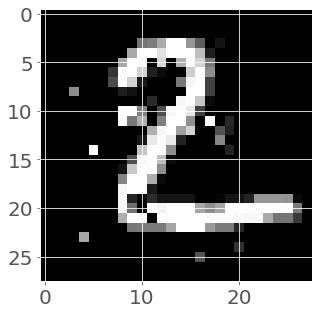

In [15]:
_ = plt.imshow(final, cmap='gray')

In [17]:
def feed_forward(im):
    
    im = im.reshape(28 * 28) 
#     im /= 255
    im = (im - 0.1307) / 0.3081
    
    x1 = im @ W[0] + B[0]
    y1 = relu(x1)

    x2 = y1 @ W[1] + B[1]
    y2 = relu(x2)

    x3 = y2 @ W[2] + B[2]

    return x3.argmax()

feed_forward(o)

8